# How to learn feature for functional maps

In this notebook, we show how to use deep functional maps to learn feature for 3d shape matching.

In [ ]:
# Set the backend for geomstats to PyTorch, commented for github test
import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"

import torch
from torch.utils.data import random_split

from geomfum.convert import P2pFromFmConverter
from geomfum.dataset.torch import PairsDataset, ShapeDataset
from geomfum.descriptor.learned import FeatureExtractor
from geomfum.forward_functional_map import ForwardFunctionalMap
from geomfum.learning.losses import (
    BijectivityLoss,
    GeodesicError,
    LaplacianCommutativityLoss,
    LossManager,
    OrthonormalityLoss,
)
from geomfum.learning.models import FMNet
from geomfum.learning.trainer import DeepFunctionalMapTrainer


First, we define our model. We can instantiate it combining feature extractors and forward logic, however, we provide some classic frameworks, like FMNet.

In [13]:
# Build the model
fmap_module = ForwardFunctionalMap(1e3, 1, True)

feature_extractor = FeatureExtractor.from_registry(
    which="diffusionnet",
    device="cuda",
    k_eig=200,
)

functional_map_model = FMNet(
    feature_extractor=feature_extractor,
    fmap_module=fmap_module,
    converter=P2pFromFmConverter(),
)


Then, we instantiate the training dataset and we split it for training purposes.

In [ ]:
TRAIN_SET_PATH = "../../../datasets/faust/train_set/"
dataset = ShapeDataset(
    TRAIN_SET_PATH, spectral=True, distances=False, device="cuda", k=30
)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_shapes, validation_shapes = random_split(dataset, [train_size, val_size])

train_shapes.distances = False  # Disable distances for training shapes
train_dataset = PairsDataset(
    train_shapes,
    pair_mode="all",
)


validation_dataset = PairsDataset(
    validation_shapes,
    pair_mode="all",
)


we build optimizer

In [4]:
optimizer = torch.optim.Adam(functional_map_model.parameters(), lr=1e-3)

Now we define the losses that we will cnsider. Again we can define our own losses, howver we provide some classic functional map energies, like the orthonormality loss.

In [5]:
# define the loss
losses = [
    OrthonormalityLoss(weight=1.0),
    BijectivityLoss(weight=1.0),
    LaplacianCommutativityLoss(weight=1e-3),
]
loss_manager = LossManager(losses)

losses = [
    GeodesicError(),
]

val_loss_manager = LossManager(losses)

We have defined a trainer for simplicity that thakes as input model, losses, train and val datasets and optimizer and manages the training loops.

In [6]:
trainer = DeepFunctionalMapTrainer(
    model=functional_map_model,
    train_loss_manager=loss_manager,
    val_loss_manager=val_loss_manager,
    train_set=train_dataset,
    val_set=validation_dataset,
    optimizer=optimizer,
    device="cuda",
    epochs=10,
)

In [ ]:
trainer.validate()

In [ ]:
mesh1 = trainer.train_set[0]["source"]["mesh"]
mesh2 = trainer.train_set[0]["target"]["mesh"]

evecs1 = mesh1.basis.vecs
evecs2 = mesh2.basis.vecs
corr1 = trainer.train_set[0]["source"]["corr"]
corr2 = trainer.train_set[0]["target"]["corr"]


fmap = torch.linalg.pinv(evecs1[corr1]) @ evecs2[corr2]

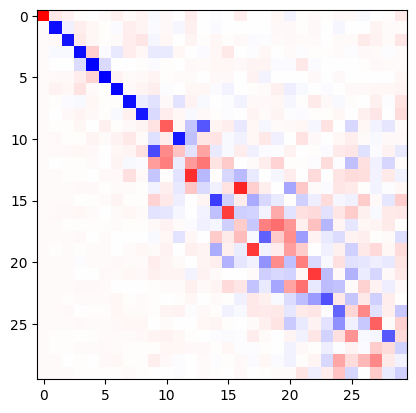

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(fmap.cpu().detach().numpy(), cmap="bwr")